In [6]:
!pip install pytorch_lightning mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 88.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 37.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.5/147.5 kB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 kB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 31.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.7/232.7 kB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 115.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 

In [7]:
import torch
import torchvision
import pytorch_lightning as pl
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from overfit.models.overfit import Overfit
from overfit.trainers.overfit import OverfitTrainer
import torch.nn.functional as F
from matplotlib.lines import Line2D
import mlflow
import os
from overfit.utils.misc import sharpen
import matplotlib
from overfit.env_settings import settings

In [8]:
class ResNetMNIST(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # define model and loss
        self.model = torchvision.models.resnet18(num_classes=10)
        self.model.conv1 = torch.nn.Conv2d(
            1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        )
        self.loss = torch.nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_no):
        # implement single training step
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        return loss

    def configure_optimizers(self):
        # choose your optimizer
        return torch.optim.RMSprop(self.parameters(), lr=0.005)


In [9]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [10]:
transform = torchvision.transforms.Compose(
    [
        # you can add other transformations in this list
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)
noise_transform=torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    AddGaussianNoise(0., 10.),
    torchvision.transforms.Normalize((0), (1)),
])

In [11]:
train_ds = MNIST("mnist", train=True, download=True, transform=noise_transform)
test_ds = MNIST("mnist", train=False, download=True, transform=noise_transform)
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)


In [12]:
src = ResNetMNIST()
trainer = pl.Trainer(
    gpus=1,
    accelerator="cuda",
    max_epochs=1,  # set number of epochs
)
# trainer.fit(src, train_dl)


/usr/local/lib/python3.9/dist-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [12]:
# trainer.save_checkpoint("resnet18_mnist.pt")
trainer.save_checkpoint("noise_resnet18_mnist.pt")


In [13]:
src = ResNetMNIST.load_from_checkpoint("noise_resnet18_mnist.pt")


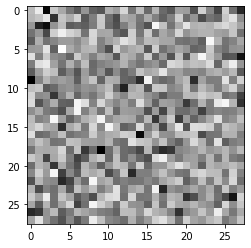

In [15]:
inputs, classes = next(iter(test_dl))
plt.imshow(inputs[0].permute(1, 2, 0), cmap="Greys")

In [28]:
inputs[0].shape

torch.Size([1, 28, 28])

In [21]:
## Initialize #{{{
matplotlib.rc("text", usetex=False)
matplotlib.rc("font", **{"family": "serif", "serif": ["Computer Modern Roman, Times"]})
colors = (
    "#BB3300",
    "#8800DD",
    "#2200FF",
    "#0099DD",
    "#00AA00",
    "#AA8800",
    "#661100",
    "#440077",
    "#000088",
    "#003366",
    "#004400",
    "#554400",
)
# }}}


[1, 1, 4]


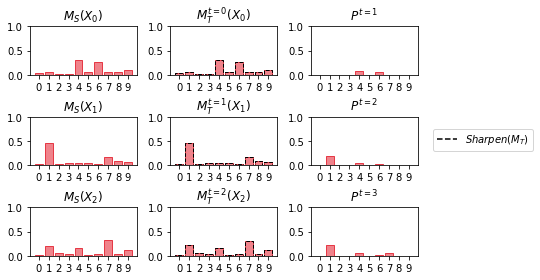

In [17]:
mlflow.set_tracking_uri(settings.MLFLOW_TRACKING_URI)
categories = ['0','1','2','3','4','5','6','7','8','9']
with mlflow.start_run() as run:
    tgt_trainer = OverfitTrainer(categories=categories)
    confidence=0.0
    tgt_trainer.set(
        pretrained_classifier=src,
        num_classes=10,
        confidence=confidence,
        weight_decay=0,
        max_lr=2,
        momentum=0,
    )
    N = [2, 5, 6]
    n = len(N)
    fig, axes = plt.subplots(n, 3, )
    X = [inputs[i].unsqueeze(0) for i in N]
    # X = [F.softmax(torch.rand((1, 28, 28)) / 10, dim=0).unsqueeze(0) for i in N]
    Y = [int(classes[i]) for i in N]
    print(Y)
    for i in range(n):
        src_pred = (
            F.softmax(tgt_trainer.model.pretrained_classifier.forward(X[i]), dim=1)
            .detach()
            .numpy()
        )
        tgt_pred = F.softmax(tgt_trainer.forward_backward(X[i]), dim=1)
        axes[i][0].set_ylim(0, 1)
        axes[i][1].set_ylim(0, 1)
        axes[i][2].set_ylim(0, 1)
        axes[i][0].set_title(f"$M_S(X_{i})$")

        axes[i][1].set_title(f"$M_T^{{t={i}}}(X_{i})$")
        axes[i][2].set_title(f"$P^{{t = {i + 1}}}$")
        # prime = F.softmax(tgt_trainer.model.prime, dim=0)
        prime = tgt_trainer.model.prime
        # axes[i][0].bar(categories, src_pred[0], facecolor='#e6394680', edgecolor='#e63946')
        axes[i][0].bar(categories, src_pred[0], facecolor='#e63946a0', edgecolor='#e63946')
        axes[i][1].bar(categories, tgt_pred.detach().numpy()[0], facecolor='#e63946a0', edgecolor='#e63946')
        axes[i][2].bar(categories, prime.detach().numpy(), facecolor='#e63946a0', edgecolor='#e63946')
        axes[i][1].bar(categories, sharpen(tgt_pred, T=1-confidence, dim=1).detach().numpy()[0], edgecolor='black', facecolor='None', linestyle='dashed')
        # axes[i][1].bar(categories, F.softmax(tgt_pred, dim=1).detach().numpy()[0], edgecolor='black', facecolor='None', linestyle='dashed')
    tgt_trainer.send_logs(run)
    fig.tight_layout(h_pad=0.5)

    handles = [
        Line2D([0], [0], color='black', linestyle='dashed', label="$Sharpen(M_T)$"),
    ]
    lgd = fig.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.savefig("backpropagg.png", dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    plt.show()


['D4-50MvitC0.0WD0.2LR0.4M0.1',
 'D4-50MvitC0.1WD0.2LR0.4M0.1',
 'D4-50MvitC0.2WD0.2LR0.4M0.1',
 'D4-50MvitC0.3WD0.2LR0.4M0.1',
 'D4-50MvitC0.9WD0.2LR0.4M0.1']